In [3]:
#%matplotlib notebook
import zipfile
import gmaps
import gmaps.datasets
import kaggle
import os
import pandas as pd
import requests
import json
from census import Census
import matplotlib.pyplot as plt
import requests
import json
from pygeocoder import Geocoder, GeocoderError
from pyzipcode import ZipCodeDatabase

# Census API Key
from config import census_key, gkey
c = Census(census_key, year=2013)
gmaps.configure(api_key=gkey)

#url for google geocode api
basegeo_url = "https://maps.googleapis.com/maps/api/geocode/json"

In [131]:
#Retrive the dataset from kaggle and move to Resources folder
os.system('kaggle datasets download -d starbucks/store-locations' )
os.system('mv -f ./store-locations.zip ./Resources/')

0

In [4]:
#Unzip the dataset downloaded from kaggle
zip_file = os.path.join('Resources', 'store-locations.zip' )
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('Resources')
zip_ref.close()

In [4]:
#Read starbucks file into a dataframe
str_file = os.path.join('Resources','directory.csv')
str_df = pd.read_csv(str_file)
str_df.head(5)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


In [5]:
#Create a dataframe for starbucks in USA 
str_df_us = str_df.loc[str_df['Country'] == 'US']
str_df_us.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
11964,Starbucks,3513-125945,Safeway-Anchorage #1809,Licensed,5600 Debarr Rd Ste 9,Anchorage,AK,US,995042300,907-339-0900,GMT-09:00 America/Anchorage,-149.78,61.21
11965,Starbucks,74352-84449,Safeway-Anchorage #2628,Licensed,1725 Abbott Rd,Anchorage,AK,US,995073444,907-339-2800,GMT-09:00 America/Anchorage,-149.84,61.14
11966,Starbucks,12449-152385,Safeway - Anchorage #1813,Licensed,1501 Huffman Rd,Anchorage,AK,US,995153596,907-339-1300,GMT-09:00 America/Anchorage,-149.85,61.11
11967,Starbucks,24936-233524,100th & C St - Anchorage,Company Owned,"320 W. 100th Ave, 100, Southgate Shopping Ctr ...",Anchorage,AK,US,99515,(907) 227-9631,GMT-09:00 America/Anchorage,-149.89,61.13
11968,Starbucks,8973-85630,Old Seward & Diamond,Company Owned,1005 E Dimond Blvd,Anchorage,AK,US,995152050,907-344-4160,GMT-09:00 America/Anchorage,-149.86,61.14


In [10]:
#Remove this code - fill in Postcode for 1 record that is missing Postcode.
#str_df_us['Postcode'].fillna(44406, inplace=True)

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [6]:
#Add a new column - Zipcode & populate it from Postcode
str_df_us['Zipcode'] = '00000'
str_df_us.Zipcode = str_df_us.Postcode.astype(str).str[0:5]
str_df_us.count()

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Brand             13608
Store Number      13608
Store Name        13608
Ownership Type    13608
Street Address    13608
City              13608
State/Province    13608
Country           13608
Postcode          13607
Phone Number      13122
Timezone          13608
Longitude         13608
Latitude          13608
Zipcode           13608
dtype: int64

In [7]:
#Get Zipcodes from Google Geocode API for records without a Poscode.

for index, row in str_df_us.iterrows():
    if (  str(   (row)['Postcode']   )  == 'nan'  ):
        #print(index, row)
        address = row['Street Address'] + ' ' + row['State/Province'] + ' ' + row['Country']
        params = { 'address' : address  , 'key' : gkey }
        #print(address)
        response = requests.get(basegeo_url, params=params).json()
        pc = response['results'][0]['address_components'][7]['short_name']
        str_df_us.loc[str_df_us['Store Number'] == row['Store Number'], 'Zipcode'] = pc

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
#Get census data
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E",
                          "B23025_002E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_002E": "Employment Labor Force",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Employment Labor Force", "Poverty Rate"]]

census_pd.head()

ConnectionError: HTTPSConnectionPool(host='api.census.gov', port=443): Max retries exceeded with url: /data/2013/acs/acs5?get=NAME%2CB19013_001E%2CB01003_001E%2CB01002_001E%2CB19301_001E%2CB17001_002E%2CB23025_002E&for=zip+code+tabulation+area%3A%2A&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x00000293B9BDA358>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

In [ ]:
#Merge Starbucks and Census dataframes on Zipcode
data_df = census_pd.merge(str_df_us, how = 'outer', on="Zipcode")
data_df.head()

In [179]:
#Get lat, long for Starbucks stores
locations = str_df_us[["Latitude", "Longitude"]].astype(float)

In [26]:
#Plot the lat long on Google map
fig = gmaps.figure()

#markers = gmaps.marker_layer(locations)
#fig.add_layer(markers)
#fig

#starbucks_layer = gmaps.symbol_layer(locations, fill_color='green', stroke_color='green', scale=2)
#fig.add_layer(starbucks_layer)
#fig


In [181]:
#Group the starbucks dataset by State
str_grp = str_df_us.groupby(by = 'State/Province')
str_grp_cnt = str_grp['Store Number'].count()

<IPython.core.display.Javascript object>


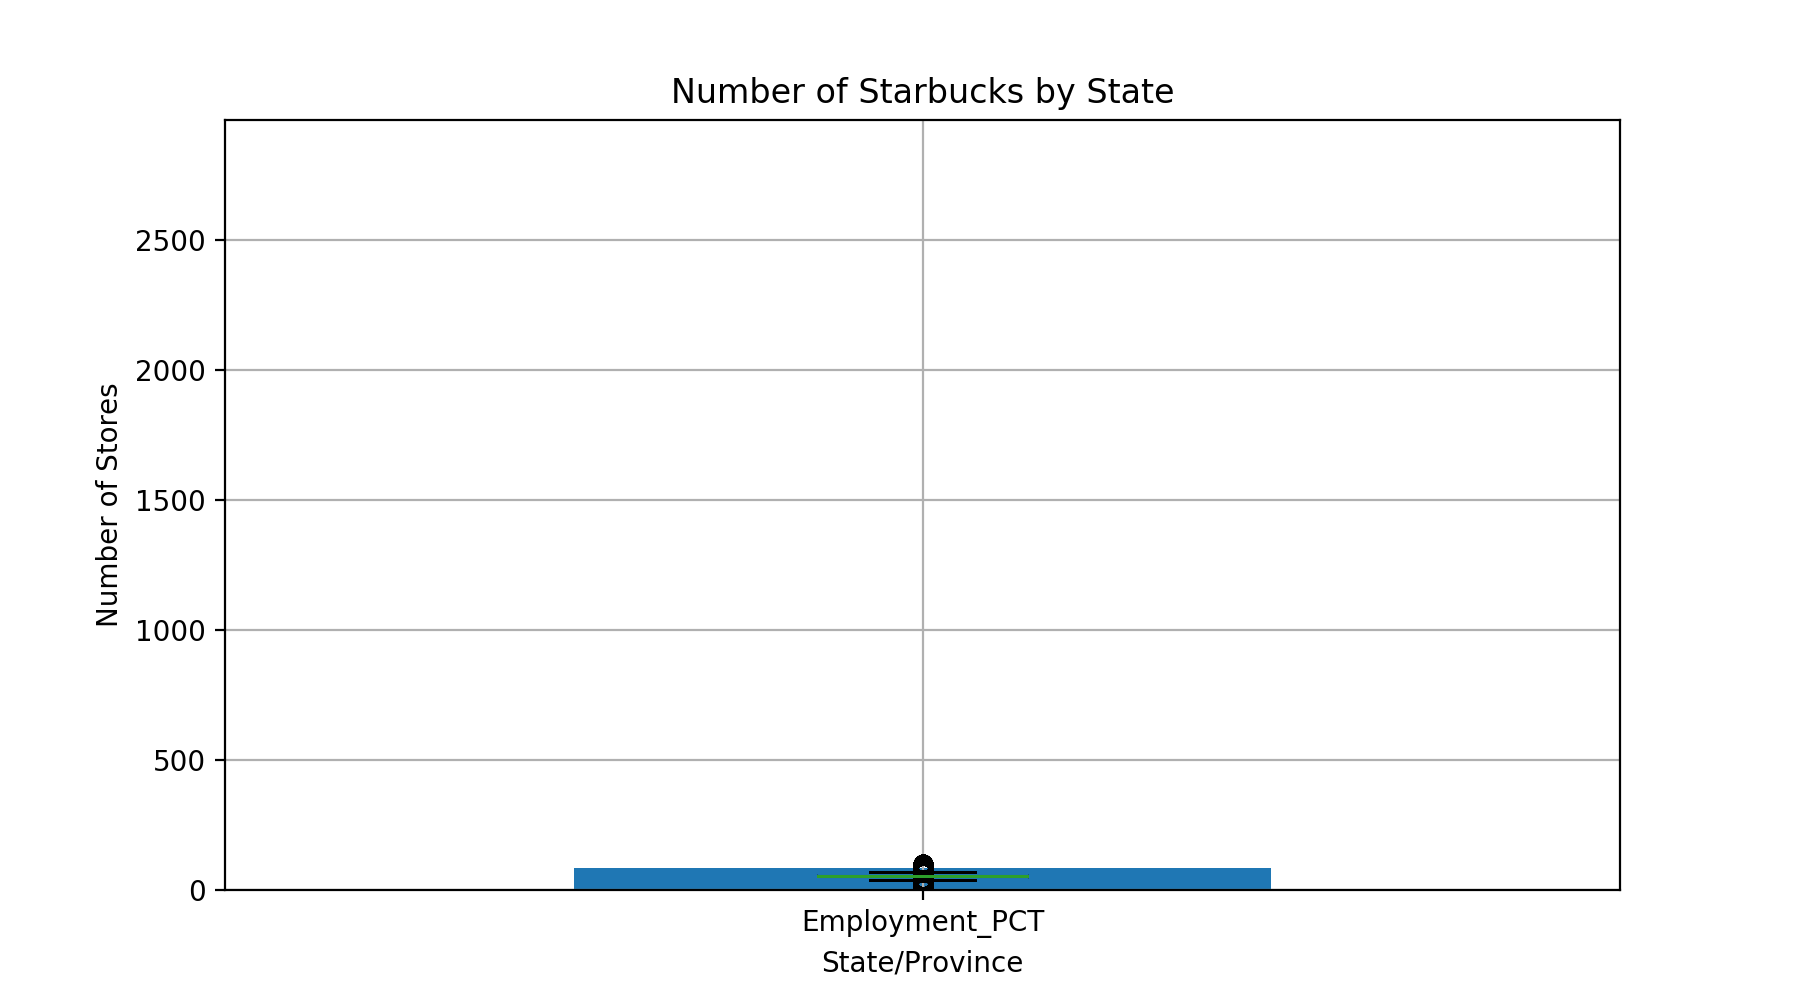

In [182]:
#Bar chart of Number of Stores by State
str_grp_cnt.plot(kind="bar", title = "Number of Starbucks by State", figsize = (9,5))
plt.ylabel("Number of Stores")
plt.savefig('Starbucks_Stores_State_Count')

In [65]:
#Read in the state vs. Lat long file
state_ll = os.path.join('Resources', 'state_lat_long.csv')
state_ll_df = pd.read_csv(state_ll)


In [67]:
#Merge the starbucks and State Lat Long dataframes
str_ll_new = str_df_us.merge(state_ll_df, how = 'inner', on="State/Province")


In [73]:
#Group the merged dataframe by State
str_ll_new_grp = str_ll_new.groupby(by = 'State/Province')
lat = str_ll_new_grp['Latitude_y'].min()
lng = str_ll_new_grp['Longitude_y'].min()

In [92]:
#Create a dataframe with State Lat Long, Number of stores
str_last_df = pd.DataFrame({ 'Lat' : lat, 'Lng' : lng, 'count' : str_grp['Store Number'].count() })

In [91]:
#Draw a heat map of Starbucks by State
#df = gmaps.datasets.load_dataset_as_df(str_last_df)
# dataframe with columns ('latitude', 'longitude', 'magnitude')
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer( str_last_df[['Lat', 'Lng']], dissipating = False, weights=str_last_df['count'], max_intensity=100, point_radius=3.0 )
heatmap_layer.dissipating = False
heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 1
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [14]:
# Find the Percentage of population that is employed & create new dataframe for Starbucks with census info
data_df['Employment_PCT'] = ''
data_df['Employment_PCT'] = data_df['Employment Labor Force'] * 100 / data_df['Population']
empl_data_df = data_df[pd.notnull(data_df['Store Number'])  & data_df['Employment Labor Force'] > 0 ]

In [18]:
# Get the median and Standard deviation for Employment Percentage
empl_mean = empl_data_df['Employment_PCT'].mean()
empl_sd = empl_data_df['Employment_PCT'].std()
print((empl_mean - empl_sd))

<class 'numpy.float64'>


<IPython.core.display.Javascript object>


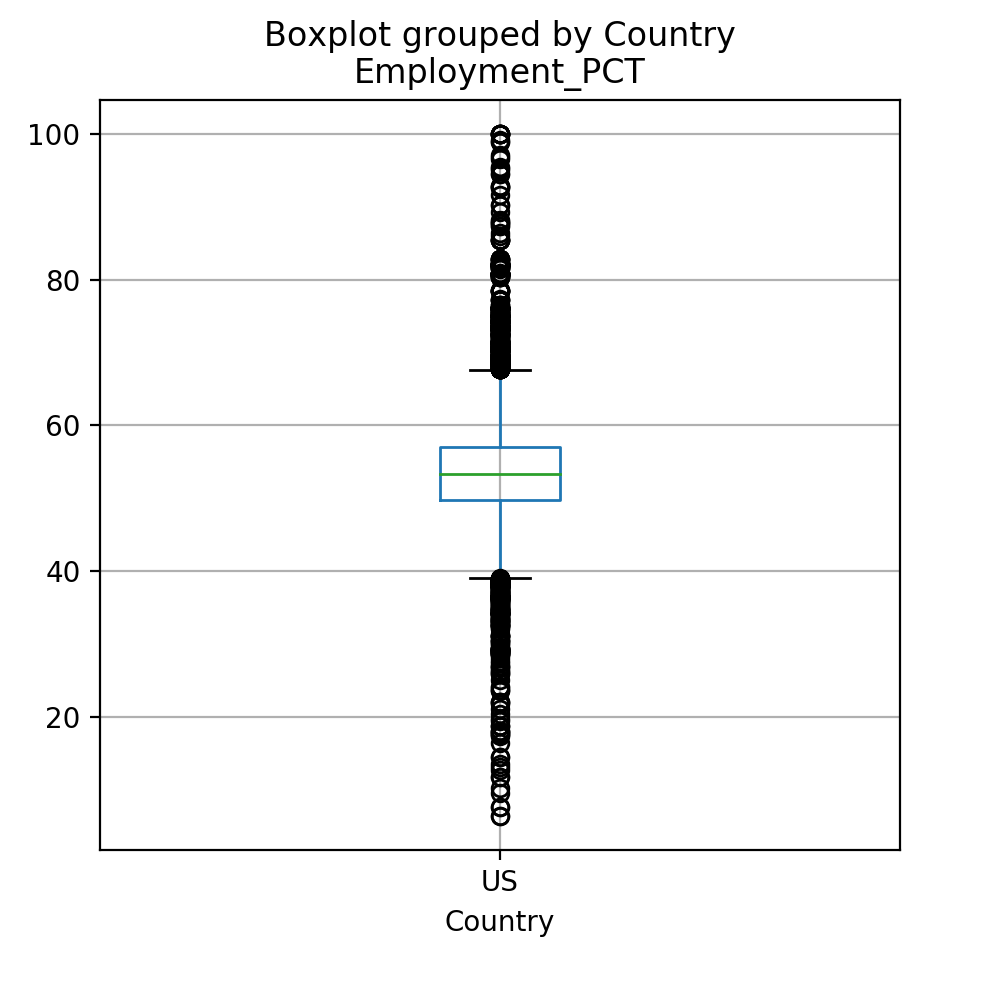

In [231]:
#Box plot for Employment Percentage
empl_data_df.boxplot(column='Employment_PCT', by='Country', figsize = (5,5))

In [34]:
#Add a new column - Recommended & populate it to 'Y' if Census attributes are withn one SD of mean
data_df['Recommended'] = 'N'

for index , row in data_df.iterrows():
    if ( (row['Employment_PCT'] > (empl_mean - empl_sd)) & (str(row['Store Number']) == 'nan') ):
        data_df.loc[data_df['Zipcode'] == row['Zipcode'], 'Recommended'] = 'Y'               
    

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y

setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y
setting to y


In [35]:
#Number of records that are Recommended
data_df['Recommended'].value_counts()

N    23602
Y    17663
Name: Recommended, dtype: int64

In [37]:
#Create a dataframe with recommended set 
rec_df = data_df.loc[data_df['Recommended'] == 'Y']

In [92]:
#Create a list with all zipcodes with 2 miles of Starbucks zipcode.
zcdb = ZipCodeDatabase()
rec_l = []

for zipcode in str_df_us.Zipcode:
    try:
        rec_l.append([z.zip for z in zcdb.get_zipcodes_around_radius(zipcode, 2)])
    except:
        print("Error")
    

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Erro

In [100]:
#flatten the list
flat_list_str = [item for sublist in rec_l for item in sublist]

In [135]:
#Add a new column 'Another Store Present' and populate to 1 if there is a store within 2 miles
rec_df['Another_Store_Present'] = rec_df.Zipcode.isin(flat_list_str).astype(int)

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [140]:
rec_df['Another_Store_Present'].value_counts()

0    16564
1     1099
Name: Another_Store_Present, dtype: int64